In [118]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Введение

В общем случае, если вы агрегируете предсказания от нескольких предсказателей, то их агрегированный ответ окажется лучше предсказанного одним оценщиком. В таком случае группа предсказателей называется **ансамблем**, а сама техника - **ансамблевым обучением**. 

Самые популярные методы ансамблевого обучения являются **бэггинг**, **бустинг** и **стеккинг**.

# Голосующие классификаторы

Предположим, мы тренируем множество классификаторов, имеющих какую-либо среднюю точность прогнозов.

Каждый из таких прогнозаторов может составлять свои собственные прогнозы на переданных данных.

Тогда самый простой способ создать лучший классификатор - агрегировать предсказания каждого классификатора в отдельности и предсказать классы для входных данных на основе наибольшего количества голосов. Такой метод классификации называется методом **жесткого голосования** (**hard voting**).

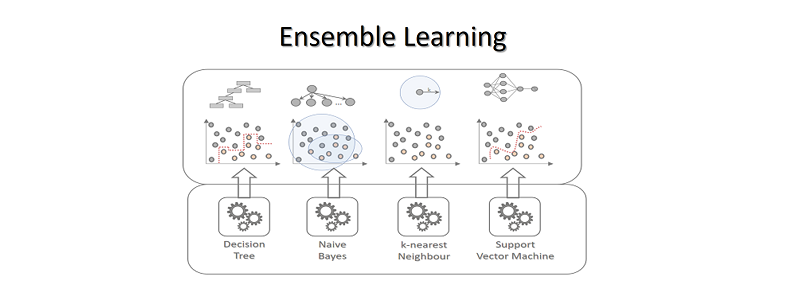

In [2]:
from IPython.display import Image
Image(data='ensemble_learning.png')

Фактически, если даже ансамбль состоит из **слабых учеников** (т.е. классификаторы, которые немного лучше случайных), то он будет представлять из себя **сильного ученика** (достигающего высокой точности прогнозирования), состояющего из достаточного количества слабых, но разнообразных классификаторов.

Разнообразие и независимость классификаторов крайне важны! Всё дело в том, что только независимые и разные классификаторы способны совершать разнообразные некореллируемые ошибки. Это довольно логично: представим, что на одних и тех же данных мы обучим одни и те же классификаторы. Тогда такой набор предсказателей будет совершать однотипные ошибки, тем самым сильно понижая точность всего ансамбля, ведь совершать ошибки они будут на одних и тех же образцах.

В реализации **sklearn** можно предсказывать всем ансамблем не только целевой класс, но и вероятность определенного класса с помощью метода **predict_proba()**. Однако, это возможно только если все оценщики в ансамбле имеют метод **predict_proba()**. В таком случае sklearn будет предсказывать целевой класс тот, средняя вероятность которого выше всех остальных классов. Такой метод предсказания называется **мягкое голосование (soft voting)**. Обычно мягкое голосование достигает точности выше, чем жесткое.

В Sklearn ансамбль на основе голосования можно построить с помощью класса **VotingClassifier**. А чтобы сделать голосование мягким, достаточно изменить параметр **voting='hard'** на **voting='soft'**, но только в том случае, если все классификаторы имеют метод predict_proba().

In [3]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=700, noise=0.3)

Теперь давайте посмотрим какова будет точность отдельных классификатор и всего ансамбля на датасете **полукругов**. 

Разделяем датасет на тренировочный и тестовый наборы данных.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Импортируем необходимые оценщики: **SVM**, **Случайный лес** и **Логистическую регрессию** на основе стохастического градиентного спуска.

In [5]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import f1_score

In [6]:
svm = SVC()
svm.fit(X_train, y_train)

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

sgd = SGDClassifier(loss='log')
sgd.fit(X_train, y_train)

SGDClassifier(loss='log')

In [7]:
f1_score(y_test, svm.predict(X_test), average='weighted')

0.9356645161290322

In [8]:
f1_score(y_test, forest.predict(X_test), average='weighted')

0.9285714285714286

In [9]:
f1_score(y_test, sgd.predict(X_test), average='weighted')

0.8782507379213919

In [10]:
voting = VotingClassifier([
    ('log', SGDClassifier(loss='log')),
    ('forest', RandomForestClassifier()),
    ('svm', SVC(probability=True))
], voting='hard')

voting.fit(X_train, y_train)

VotingClassifier(estimators=[('log', SGDClassifier(loss='log')),
                             ('forest', RandomForestClassifier()),
                             ('svm', SVC(probability=True))])

In [11]:
f1_score(y_test, voting.predict(X_test), average='weighted')

0.9356645161290322

В общем случае, как можно заметить, точность ансамбля обычно выше отдельных классификаторов, но это не всегда так.

Заявлять, что ансамблевое обучение всегда лучше - совсем неверно. Есть мнение, что когда ансамбль состоит из моделей, склонных к переобучению, а то есть имеющих большую дисперсию, то следует предпочесть **бэггинг**. Однако, если модели в ансамбле склонны к смещению, то стоит предпочесть **бустинг**.

Из-за неправильного выбора моделей, а также метода ансамблевого обучения, ваш ансамбль не всегда будет лучше отдельно взятой модели. Тут нужно подбирать, сравнивать и смотреть на практике для каждого отдельного случая.

Бэггинг, бустинг и т.п. будет рассмотрен далее.

# Бэггинг

Как говорилось ранее, чтобы сделать набор разнообразных классификаторов, можно использовать различные обучающие алгоритмы. Однако, существует ещё один подход, подразумевающий использование одного и того же алгоритма обучения для каждого оценщика, но обучение в нем происходит на разных случайных поднаборах данных. 

Когда выборка данных выполняется с постоянной заменой, то метод называется **бэггингом** (bagging - bootstrap aggregating). В противном случае, когда замена не осуществляется - это называется **вставкой**.

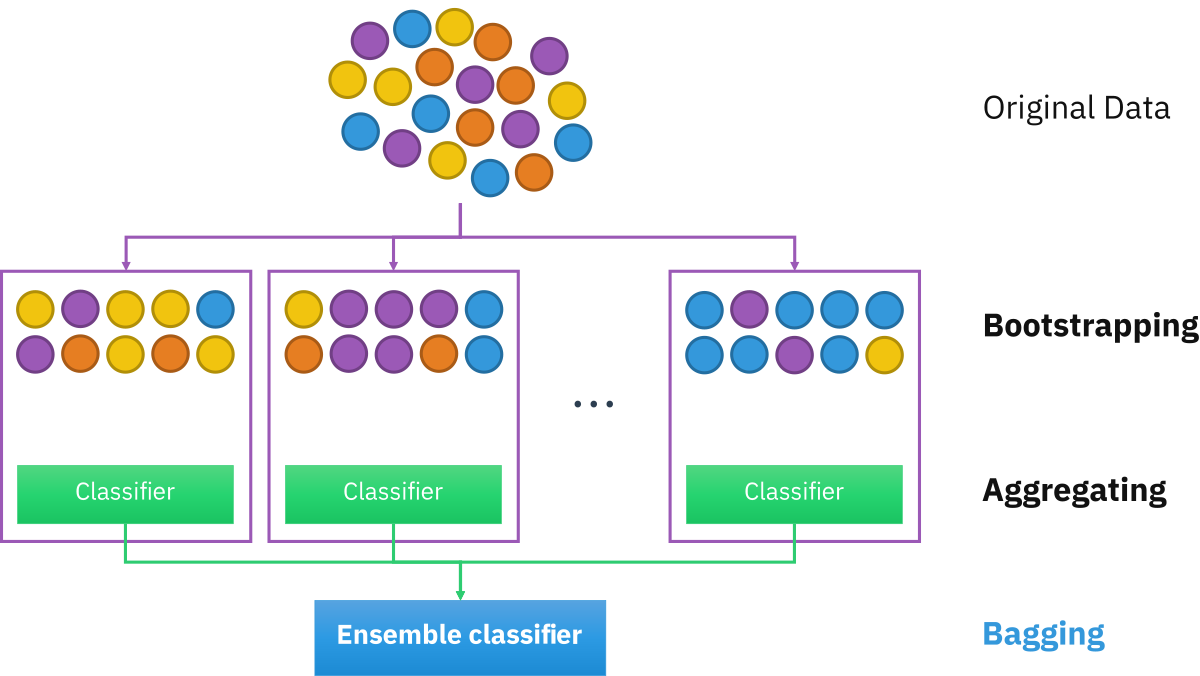

In [12]:
from IPython.display import Image
Image(data='bagging.png')

В sklearn существует очень удобные классы для реализации методов вставки и бэггинга - **BaggingClassifier** (или BaggingRegressor). При этом, чтобы осуществить метод вставки, нужно поставить параметр **bootstrap=False**. 

При этом, BaggingClassifier автоматически будет использовать soft голосование, если базовый классификатор может оценивать вероятности.

In [13]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Давайте с помощью класса `BaggingClassifier` реализуем случайный лес и сравним его с реализацией `RandomForestClassifier`.

In [14]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=100)
forest = RandomForestClassifier()

bagging.fit(X_train, y_train)
forest.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
f1_score(y_test, bagging.predict(X_test))

0.9426751592356688

In [16]:
f1_score(y_test, forest.predict(X_test))

0.935064935064935

Как можно заметить точности у обеих реализаций приблизительно одинаковые.

In [17]:
def plot_moons(X, y):
    ax = plt.gca()
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0])
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1])
    plt.xlabel("$X_0$", fontsize=18)
    plt.ylabel("$X_1$", fontsize=18, rotation=0, labelpad=10)
    ax.tick_params(labelsize=14)
    
def plot_tree_predictions(tree, axis):
    x1s = np.linspace(axis[0], axis[1], 100)
    x2s = np.linspace(axis[2], axis[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = tree.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#9494ff','#ff7e57'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    plt.axis(axis)

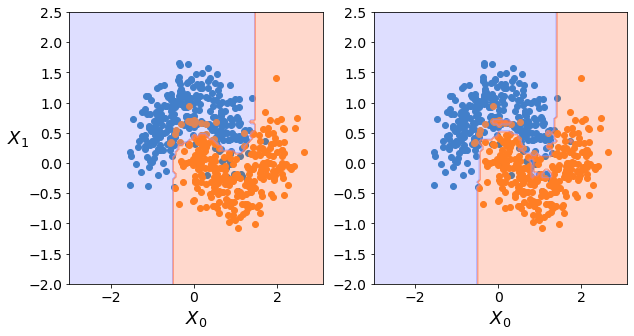

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_moons(X_train, y_train)
plot_tree_predictions(bagging, [-3, 3.1, -2, 2.5])

plt.subplot(122)
plot_moons(X_train, y_train)
plot_tree_predictions(forest, [-3, 3.1, -2, 2.5])
plt.ylabel('')
plt.show()

Как можно заметить из графиков, даже границы решений у этих двух методов одинаковые.

А теперь давайте сравним дерево принятия решений и бэггинг.

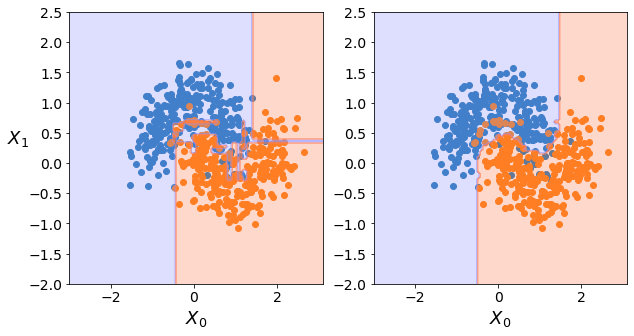

In [19]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_moons(X_train, y_train)
plot_tree_predictions(tree, [-3, 3.1, -2, 2.5])

plt.subplot(122)
plot_moons(X_train, y_train)
plot_tree_predictions(bagging, [-3, 3.1, -2, 2.5])
plt.ylabel('')
plt.show()

Как можно заметить из графика что дерево, что лес на основе бэггинга, совершают одни и те же ошибки, что говорит о том, что смещение моделей приблизительно **одинаковы**. Однако, дисперсия бэггинга гораздо меньше, а потом границы принятия решений более гладкие и правильные, чем у одиночного дерева.

# Out-of-Bag оценка

Когда вы используете бэггинг, некоторые образцы могут обучаться некоторыми оценщиками, в то время как другие образцы могут быть не затронуты вовсе. Такие образцы называются **out-of-bag** образцами.

Поскольку оценщики никогда не видели oob образцов, то производительность полученной модели может быть измерена посредством oob датасета.

In [20]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, oob_score=True)
bagging.fit(X_train, y_train)
bagging.oob_score_

0.8964285714285715

In [21]:
f1_score(y_test, bagging.predict(X_test))

0.948051948051948

# Extra trees

Деревья можно сделать ещё более случайными, если теперь вместо отыскания наилучшего граничного значения для каждого признака, использовать случайную границу для признака.

Лес, состоящий из таких деревьев, называется  **экстремальный случайный лес**. Опять же, такой метод променивает большее смещение на меньшую дисперсию. И к тому же, экстримальный лес обучается быстрее, чем случайный.

In [22]:
from sklearn.ensemble import ExtraTreesClassifier

In [23]:
extra_forest = ExtraTreesClassifier()
extra_forest.fit(X_train, y_train)

ExtraTreesClassifier()

In [24]:
f1_score(y_test, forest.predict(X_test))

0.935064935064935

In [25]:
f1_score(y_test, extra_forest.predict(X_test))

0.915032679738562

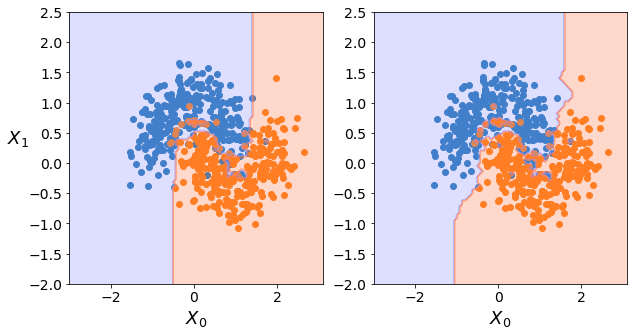

In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_moons(X_train, y_train)
plot_tree_predictions(forest, [-3, 3.1, -2, 2.5])

plt.subplot(122)
plot_moons(X_train, y_train)
plot_tree_predictions(extra_forest, [-3, 3.1, -2, 2.5])
plt.ylabel('')
plt.show()

Нельзя однозначно сказать, что в какой момент будет лучше для конкретных данных. Самый верный способ найти оптимальное решение - это сравнить на кросс-валидации оба варианта.

# Оценка важности признаков

Ещё одно очень важное и полезное качество случайных лесов - это то, что они легко могут показать важность каждого признака для классификации.

Sklearn измеряет важность признаков, посматривая весь лес и определяя как много какой признак используют узлы для уменьшения загрязненности узлов в среднем.

Оценка важности признаков происходит автоматически сразу после обучения. А получить показатели важности можно с помощью **feature_importances_** переменной.

In [27]:
from sklearn.datasets import load_wine

wine = load_wine()

In [28]:
wine['feature_names']

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [29]:
X, y = wine['data'], wine['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
f1_score(y_test, forest.predict(X_test), average='weighted')

0.9723297491039428

Для датасета **вин** мы можем посмотреть, какие признаки являются ключевыми, а какие почти не играют роль.

In [31]:
for feature, importance in sorted(zip(wine['feature_names'], forest.feature_importances_), key=lambda x: x[1], reverse=True):
    print(f'{feature}:', f'{round(importance, 3)}')

od280/od315_of_diluted_wines: 0.162
proline: 0.162
alcohol: 0.151
flavanoids: 0.131
color_intensity: 0.126
total_phenols: 0.077
hue: 0.06
alcalinity_of_ash: 0.029
magnesium: 0.025
malic_acid: 0.024
proanthocyanins: 0.024
nonflavanoid_phenols: 0.016
ash: 0.014


# Бустинг

Один из способов в создании нового предсказателя, который корректировал бы предыдущего, заключается в "обращении внимания" к тренировочным образцам, на которых предыдущий оценщик недообучился.

Это приводит к тому, что новые оценщики всё больше и больше "концентрируются" на сложных случаях. Такая техника и называется **AdaBoost**.

## AdaBoost

Один из способов в создании нового предсказателя, который корректировал бы предыдущего, заключается в "обращении внимания" к тренировочным образцам, на которых предыдущий оценщик недообучился.

Это приводит к тому, что новые оценщики всё больше и больше "концентрируются" на сложных случаях. Такая техника и называется **AdaBoost**.

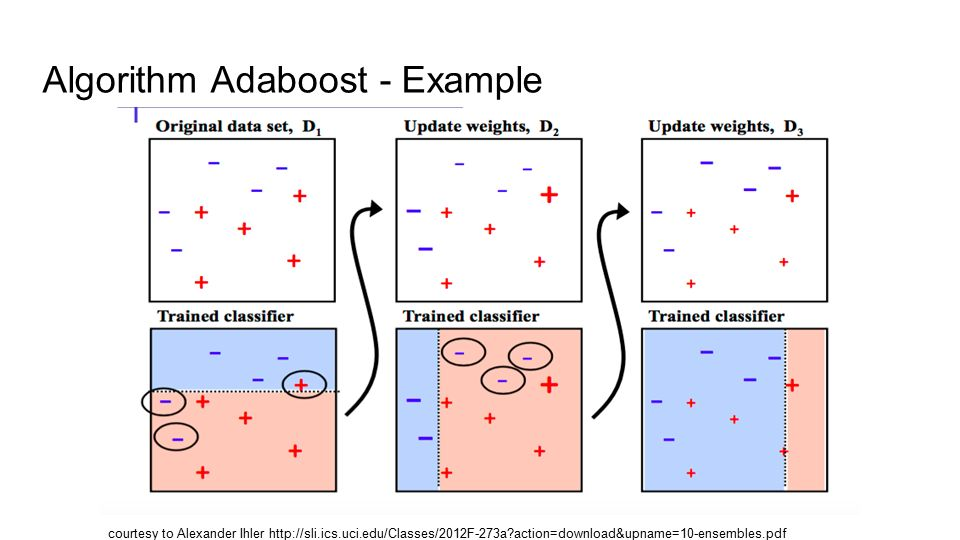

In [32]:
from IPython.display import Image
Image(data='adaboost.png')

Рассмотрим, как работает AdaBoost. Изначально каждый образец имеет вес $w^{(i)}=\frac1m$. Тогда, как только первый предсказатель обучился, его взвешенный показатель ошибки $r_1$ вычисляется по формуле:

$$r_j=\frac{\sum_{i=1}^mw^{(i)}\ при\ \hat{y}^{(i)}_j \ne y^{(i)}}{\sum_{i=1}^mw^{(i)}}$$

Затем вес предсказатель $\alpha_j$ вычисляется как:

$$\alpha_j=\eta\log\frac{1-r_j}{r_j}$$

Где $\eta$ - скорость обучения. При этом, чем точнее оценщик, тем выше его вес. Если он просто выбирает наугад, то его вес близок к нулю, т.к. $r_j=\frac12$, иначе если $r_j$ довольной большой, то вес будет отрицательным, и наоборот.

Ну и наконец, AdaBoost обновляет веса образцов, используя выражение:

$$for\ i=1,2,...,m \\
w^{(i)} \leftarrow \begin{cases}
w^{(i)} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ if\ \hat{y}_j^{(i)}=y^{(i)} \\
w^{(i)}\exp(\alpha_j) \ \ if\ \hat{y}_j^{(i)}\ne y^{(i)}
\end{cases}$$

Затем все веса образцов нормализуются - делятся на $\sum_{i=1}^mw^{(i)}$.

Чтобы сделать предсказание, AdaBoost просто вычисляет предсказания от всех оценщиков и сравнивает их, используя веса этих оценщиков $\alpha_j$. Предсказанный класс - класс, имеющий наибольшее количество взвешенных голосов $\alpha_j$:

$$\hat{y}(x)=arg\max_k\sum_{j=1}^N\alpha_j\ при\ \hat{y}_j(x)=k$$

Sklearn использует многоклассовую версию AdaBoost - **SAMME** (Stagewise Additive Modeling using a Multiclass Exponential loss
function). Когда только два класса, то SAMME эквивалента обычному AdaBoost.

Когда предикторы могут оценивать вероятности (soft vote), то SAMME можно заменить на **SAMME.R** (где R - означает real), использующий вероятности классов и, как правило, выполняющееся лучше.

Класс, который реализует AdaBoost - **AdaBoostClassifier**.

In [33]:
X, y = make_moons(n_samples=700, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100, algorithm='SAMME.R')
adaboost.fit(X_train, y_train)
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

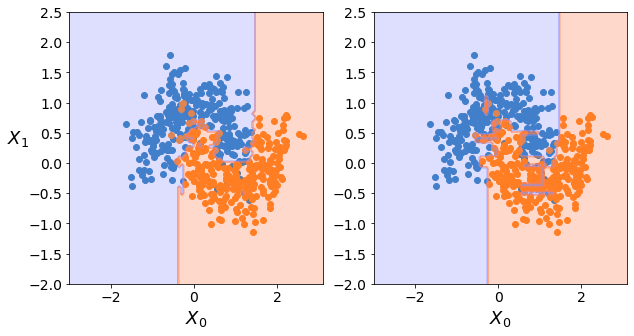

In [35]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_moons(X_train, y_train)
plot_tree_predictions(forest, [-3, 3.1, -2, 2.5])

plt.subplot(122)
plot_moons(X_train, y_train)
plot_tree_predictions(adaboost, [-3, 3.1, -2, 2.5])
plt.ylabel('')
plt.show()

In [36]:
f1_score(y_test, forest.predict(X_test))

0.9006622516556292

In [37]:
f1_score(y_test, adaboost.predict(X_test))

0.8496732026143792

## Градиентный бустинг

Ещё один популярный алгоритм бустинга - **градиентный бустинг**. Точно так же, как и AdaBoost, градиентный бустинг последовательно добавляет предсказатели в ансамбль, каждый раз улучшая предыдущий.

Однако, вместо настройки весов образцов на каждой итерации этот метод пытается обучить каждый новый оценщик на остаточных ошибках предыдущего оценщика.

Отметим, что градиентный бустинг прекрасно справляется с задачами регресии. Это называется **Gradient Tree Boosting** или **Gradient Boosted Regression Trees (GBRT)**.

In [38]:
X = np.linspace(-3, 5, 200)
y = 3*X**2 - 5*X + 3 + 5 * np.random.randn(200)

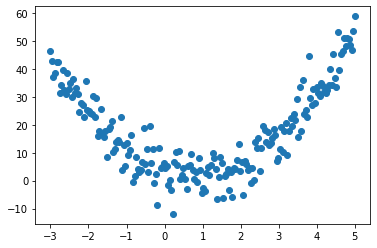

In [39]:
plt.scatter(X, y)
plt.show()

Реализуем метод градиентного бустинга "вручную".

In [40]:
from sklearn.tree import DecisionTreeRegressor

Обучим три отдельных дерева: первое на оригинальных данных, второе на ошибках первого дерева, а третье - на ошибках второго.

In [41]:
tree1 = DecisionTreeRegressor(max_depth=3)
tree1.fit(X.reshape(-1, 1), y)

DecisionTreeRegressor(max_depth=3)

In [42]:
y2 = y - tree1.predict(X.reshape(-1, 1))
tree2 = DecisionTreeRegressor(max_depth=3)
tree2.fit(X.reshape(-1, 1), y2.reshape(-1, 1))

DecisionTreeRegressor(max_depth=3)

In [43]:
y3 = y2 - tree2.predict(X.reshape(-1, 1))
tree3 = DecisionTreeRegressor(max_depth=3)
tree3.fit(X.reshape(-1, 1), y3.reshape(-1, 1))

DecisionTreeRegressor(max_depth=3)

Таким образом, мы вручную реализовали ансамбль из трёх деревьев.

In [44]:
X_new = np.array([[3]])

Он может делать предсказания для нового образца, просто складывая предсказания всех трёх оценщиков:

In [45]:
tree1.predict(X_new), tree2.predict(X_new), tree3.predict(X_new)

(array([16.39598705]), array([-0.04342301]), array([-7.64764568]))

In [46]:
y_pred = sum(tree.predict(X_new) for tree in (tree1, tree2, tree3))
y_pred

array([8.70491837])

Отобразим на графике то, как градиентный бустинг улучшает модели.

In [53]:
def plot_predictions(trees, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(tree.predict(x.reshape(-1, 1)) for tree in trees)
    plt.plot(X, y, data_style, label=data_label)
    plt.plot(x, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

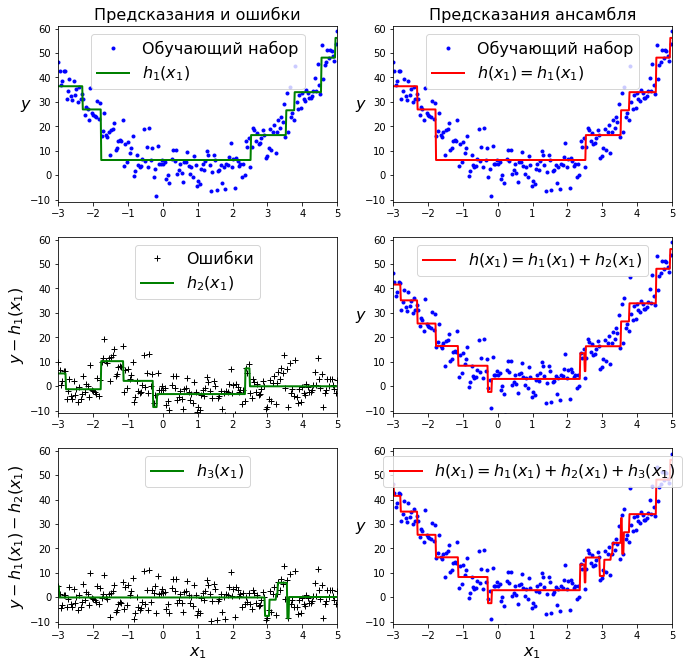

In [54]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree1], X, y, axes=[-3, 5, -11, 61], label="$h_1(x_1)$", style="g-", data_label="Обучающий набор")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Предсказания и ошибки", fontsize=16)

plt.subplot(322)
plot_predictions([tree1], X, y, axes=[-3, 5, -11, 61], label="$h(x_1) = h_1(x_1)$", data_label="Обучающий набор")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Предсказания ансамбля", fontsize=16)

plt.subplot(323)
plot_predictions([tree2], X, y2, axes=[-3, 5, -11, 61], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Ошибки")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree1, tree2], X, y, axes=[-3, 5, -11, 61], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree3], X, y3, axes=[-3, 5, -11, 61], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree1, tree2, tree3], X, y, axes=[-3, 5, -11, 61], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

## Градиентный бустинг с ранней остановкой

У градиентного бустинга есть гиперпараметр скорости обучения. Если установить его в маленькое значение, к примеру, 0.1, то вам потребуется большее число деревьев в ансамбле, чтобы обучиться на тренировочном наборе, но при этом предсказания обычно становятся лучше. Такая техника регуляризации называется **сокращение** (**shrinkage**).

Давайте продемонстрируем пример, когда мы обучим ансамбли с маленькой скоростью обучения и разными количествами деревьев в нём.

In [59]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt1 = GradientBoostingRegressor(n_estimators=3, learning_rate=0.1)
gbrt1.fit(X.reshape(-1, 1), y)

gbrt2 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1)
gbrt2.fit(X.reshape(-1, 1), y)

GradientBoostingRegressor(n_estimators=200)

Text(0.5, 1.0, '$lr = 0.1, n\\_estimators = 200$')

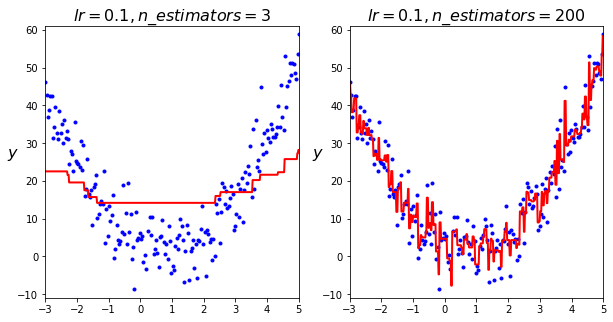

In [61]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plot_predictions([gbrt1], X, y, axes=[-3, 5, -11, 61])
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("$lr = 0.1, n\_estimators = 3$", fontsize=16)

plt.subplot(122)
plot_predictions([gbrt2], X, y, axes=[-3, 5, -11, 61])
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("$lr = 0.1, n\_estimators = 200$", fontsize=16)

На первом графике мы можем видеть недообучение, а на втором - переобучение модели.

Тогда, чтобы найти оптимальное количество деревьев в таком ансамбле, мы можем использовать **ранюю остановку** (early stopping). Самый простой способ это сделать - использовать функцию **staged_predict()**. Она возвращает предсказанные значения ансамблем на каждой итерации, где итерация представляет собой количество деревьев в ансамбле (1, 2, 3, ...). Соответственно, определив ошибку предсказания на каждой итерации, мы можем выбрать оптимальное количество деревьев в ансамбле.

In [62]:
from sklearn.metrics import mean_squared_error

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

gbrt = GradientBoostingRegressor(n_estimators=100)
gbrt.fit(X_train.reshape(-1, 1), y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test.reshape(-1, 1))]
best_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(n_estimators=best_n_estimators)
gbrt_best.fit(X_train.reshape(-1, 1), y_train)

GradientBoostingRegressor(n_estimators=68)

Взглянем на то, как изменяется ошибка в зависимости от количества деревьев в ансамбле.

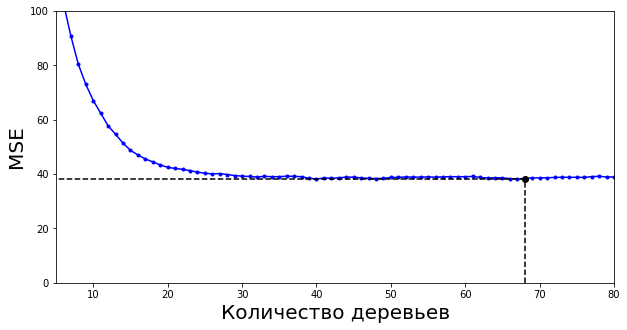

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(errors, 'b.-')
plt.plot([0, best_n_estimators], 
         [errors[best_n_estimators-1], errors[best_n_estimators-1]],
         'k--')
plt.plot([best_n_estimators, best_n_estimators], 
         [0, errors[best_n_estimators-1]],
         'k--')
plt.plot(best_n_estimators, errors[best_n_estimators-1], 'ko')
plt.axis([5, 80, 0, 100])
plt.xlabel('Количество деревьев', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.show()

А теперь построим графики ансамблей - обычного нерегуляризованного и второго - с наилучшим количеством деревьев.

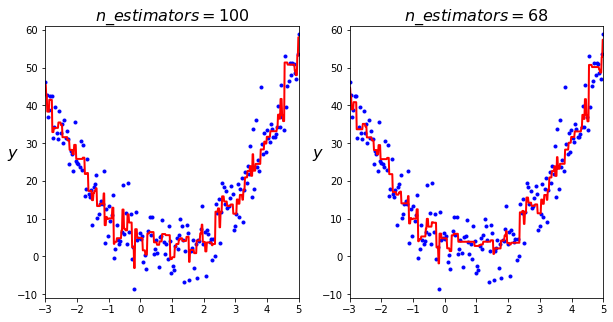

In [85]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-3, 5, -11, 61])
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("$n\_estimators = 100$", fontsize=16)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-3, 5, -11, 61])
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title(f"$n\_estimators = {best_n_estimators}$", fontsize=16)

plt.show()

Минимальная ошибка:

In [86]:
print(f'Минимальная ошибка при {best_n_estimators} деревьях: {errors[best_n_estimators-1]}')

Минимальная ошибка при 68 деревьях: 38.153247127979675


Помимо всего прочего, в sklearn, как и говорилось ранее, есть возможность использовать инкрементальное обучение (онлайн-обучение про это же). Это делается с помощью параметра **warm_start=True**, который позволяет продолжить обучение модели, а не начать его сначала при запуске метода **fit()**.

# XGBoost

Но стоит сказать о другом: для Python существует оптимизированная реализация градиентного бустинга в виде библиотеки **XGBoost**, которая расшифровывается как **экстремальный градиентный бустинг**. Эта модель экстремально быстрая и масштабируемая. Плюс ко всему, XGBoost часто является ключевым компонентом в выигрышных моделях на соревнованиях.

In [91]:
from xgboost import XGBRegressor

In [111]:
xgb = XGBRegressor()
xgb.fit(X_train.reshape(-1, 1), y_train,
        eval_set=[(X_test.reshape(-1, 1), y_test)], 
        early_stopping_rounds=2)

error = mean_squared_error(y_test, xgb.predict(X_test.reshape(-1, 1)))
error

[0]	validation_0-rmse:18.63439
[1]	validation_0-rmse:13.68108
[2]	validation_0-rmse:10.45464
[3]	validation_0-rmse:8.40364
[4]	validation_0-rmse:7.08303
[5]	validation_0-rmse:6.42985
[6]	validation_0-rmse:6.10057
[7]	validation_0-rmse:5.91801
[8]	validation_0-rmse:5.88680
[9]	validation_0-rmse:5.95344
[10]	validation_0-rmse:5.99919


34.65440868104657

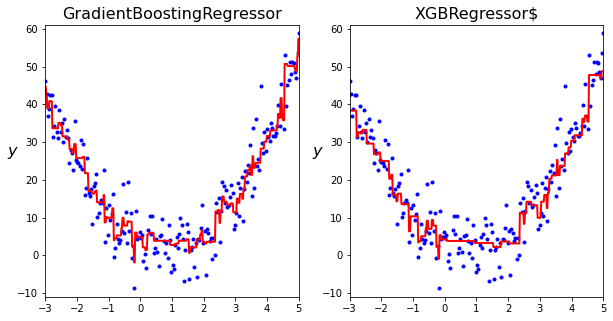

In [117]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plot_predictions([gbrt_best], X, y, axes=[-3, 5, -11, 61])
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title(f"GradientBoostingRegressor", fontsize=16)

plt.subplot(122)
plot_predictions([xgb], X, y, axes=[-3, 5, -11, 61])
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title(f"XGBRegressor$", fontsize=16)

plt.show()

# Стэкинг

Третий ансамблевый метод - стэкинг. Он основан на простой идее: вместо того, чтобы использовать тривиальные способы агрегации предсказаний (как жесткое голосование) от всех предсказателей ансамбля, стэкинг обучает модель, которая выполняет эту агрегацию.

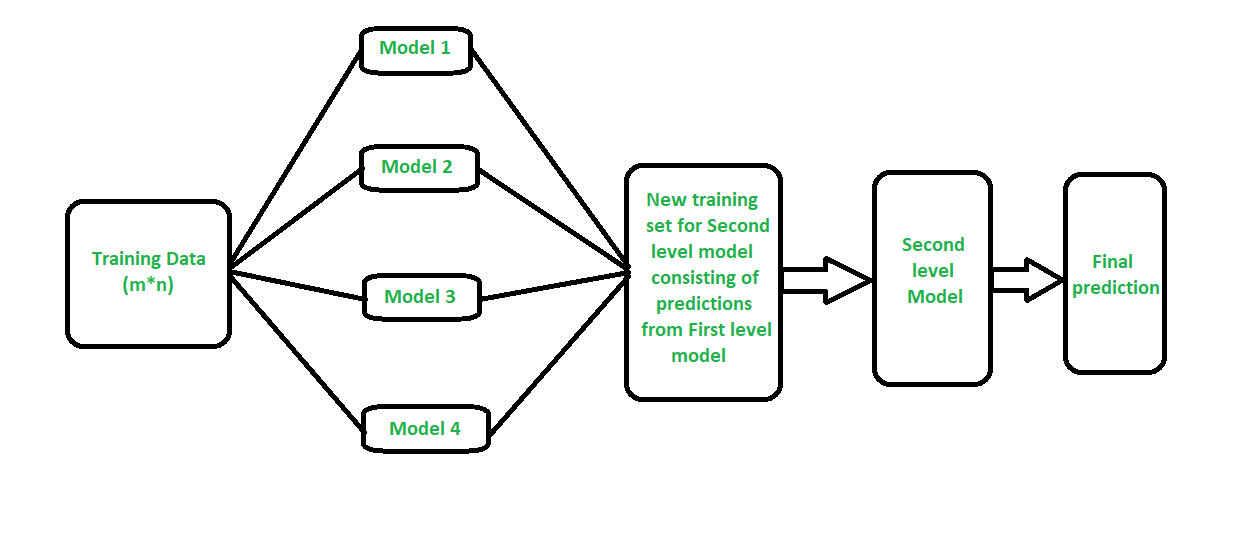

In [136]:
from IPython.display import Image
Image(data='stacking.png')

Допустим, каждая из моделей предсказывает различное значение (для задачи регрессии), тогда финальный предсказатель (называемый **блэндером** или **мета учеником**) берёт все эти предсказания и составляет на их основе свой финальный прогноз.

In [123]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

In [127]:
estimators = [
    ('random_forest', RandomForestRegressor()),
    ('xgboost', XGBRegressor()),
    ('svm', SVR()),
    ('lasso', Lasso())
]

In [128]:
reg = StackingRegressor(estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=50))

In [131]:
reg.fit(X_train.reshape(-1, 1), y_train)

StackingRegressor(estimators=[('random_forest', RandomForestRegressor()),
                              ('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
 

In [132]:
mean_squared_error(y_test, reg.predict(X_test.reshape(-1, 1)))

45.42136023145499

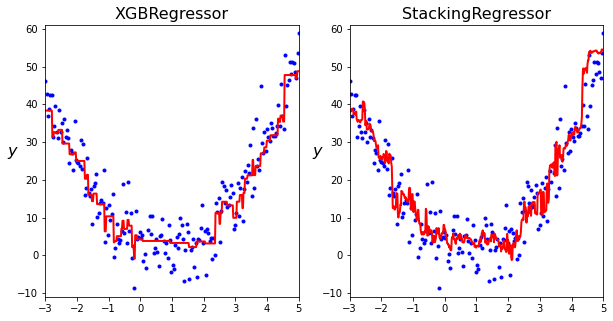

In [135]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plot_predictions([xgb], X, y, axes=[-3, 5, -11, 61])
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title(f"XGBRegressor", fontsize=16)

plt.subplot(122)
plot_predictions([reg], X, y, axes=[-3, 5, -11, 61])
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title(f"StackingRegressor", fontsize=16)

plt.show()